In [5]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#ref 
#https://github.com/garima-mahato/END2/blob/main/Session5-FirstHands-on/Sentiment_Analysis_using_LSTM_RNN.ipynb

In [7]:
path='/content/drive/MyDrive/ENDB2/SESSION_05/data_weights/'

In [8]:
#Install pytreebank
! pip install pytreebank==0.2.7
! pip install google_trans_new
import nltk 
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext.legacy
from torchtext import datasets

import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import spacy
import nltk
from nltk.corpus import stopwords, wordnet

import pytreebank

import google_trans_new 
from google_trans_new import google_translator  
import random

#from sklearn.model_selection import train_test_split

import os, pickle

In [10]:
#GET DATASET
dataset = pytreebank.load_sst()

In [11]:
#SEE ONE LABEL AND TEXT OF TRAIN DATASET 
dataset['train'][0].to_labeled_lines()[0]

(3,
 "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .")

In [12]:
#LETS SEPARATE TRAIN AND TEST 
data_train = [example.to_labeled_lines()[0] for example in dataset["train"]]
data_test = [example.to_labeled_lines()[0] for example in dataset["test"]]

In [13]:
len(data_train), len(data_test)

(8544, 2210)

In [14]:
train = pd.DataFrame(data_train, columns = ['label', 'sentence'])
test = pd.DataFrame(data_test, columns = ['label', 'sentence'])

In [15]:

train.head()

,label,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,3,Singer/composer Bryan Adams contributes a slew...
3,2,You 'd think by now America would have had eno...
4,3,Yet the act is still charming here .


In [16]:
test.head()

,label,sentence
0,2,Effective but too-tepid biopic
1,3,If you sometimes like to go to the movies to h...
2,4,"Emerges as something rare , an issue movie tha..."
3,2,The film provides some great insight into the ...
4,4,Offers that rare combination of entertainment ...


In [17]:
len(train),len(test)

(8544, 2210)

In [18]:
# AUGMENTATION STRATEGY 
# WE WILL APPLY BELOW 4 AUGMENTATION STRATEGY 
# RANDOM INSERT (5%)
# RANDOM DELETE (5%)
# RANDOM SWAP   (20%)
# BACK TRANSLATE (70%)
# we will chnage the ratio in later phase 

In [19]:
#BACK TRANSLATE 


In [20]:
def back_translate(sentence):
  """ Google translate the input sentence and translate back"""
  available_langs = list(google_trans_new.LANGUAGES.keys()) 
  trans_lang = random.choice(available_langs) 
  translator = google_translator()  
  translate_text = translator.translate(sentence,lang_tgt=trans_lang) 
  translate_back = translator.translate(translate_text,lang_tgt='en')
  return (translate_back)

# #TEST 
# result= back_translate('India has recently overtaken the US in terms of the number of people who have received at least one dose of the Covid vaccine')
# print(result)

In [21]:
# RANDOM DELETE 

In [22]:
def random_deletion(sentence, p=0.5): 
    words = sentence.split()
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return (' '.join(remaining))

#TEST 
result= random_deletion('India has recently overtaken the US in terms of the number of people who have received at least one dose of the Covid vaccine')
print(result)

has overtaken the terms the of received least dose of the


In [23]:
# RANDOM SWAp


In [24]:
def random_swap(sentence, n=5): 
    words = sentence.split()
    if len(words) == 1: # return if single word
        return words
    length = range(len(words)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        words[idx1], words[idx2] = words[idx2], words[idx1] 
    return (' '.join(words))

#TEST 
result= random_swap('India has recently overtaken the US in terms of the number of people who have received at least one dose of the Covid vaccine')
print(result)

US has recently overtaken of India in terms of of number received dose who have the at least one people the the Covid vaccine


In [25]:
# RANDOM INSERT

In [26]:
def remove_stopwords(sentence):
    from nltk.corpus import stopwords
    tokenized = sentence #custom_tokenize(sentence) #data['text'].apply(custom_tokenize) # Tokenize tweets
    lower_tokens = [t.lower() for t in tokenized] #tokenized.apply(lambda x: [t.lower() for t in x]) # Convert tokens into lower case
    alpha_only = [t for t in lower_tokens if t.isalpha()] #lower_tokens.apply(lambda x: [t for t in x if t.isalpha()]) # Remove punctuations
    no_stops = [t for t in alpha_only if t not in stopwords.words('english')] #alpha_only.apply(lambda x: [t for t in x if t not in stopwords.words('english')]) # remove stop words

    return no_stops

def get_synonyms(word):
    import nltk
    from nltk.corpus import wordnet
    synonyms = []
      
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonyms.append(l.name())
            # if l.antonyms():
            #     antonyms.append(l.antonyms()[0].name())
    synonyms = list(set(synonyms))
    if len(synonyms) > 0:
      new_synonym = random.choice(synonyms)
    else:
      new_synonym = word

    return new_synonym
def random_insertion(sentence, n=4): 
    from random import randrange
    sentence= sentence.split()
    words = remove_stopwords(sentence) 
    if len(words)<=0:
      words = sentence
    for _ in range(n):
        word = random.choice(words)
        new_synonym = get_synonyms(word)
        sentence.insert(randrange(len(sentence)+1), new_synonym)
    return " ".join(sentence)

#TEST 
result= random_insertion('India has recently overtaken the US in terms of the number of people who have received at least one dose of the Covid vaccine')
print(result)

India has recently overtaken vaccinum the US in terms of the number of vaccine people who have received at least one dose late uracil of the Covid vaccine


In [27]:
BACK_TRANSLATE_FRACTION = 0.10
RANDOM_INSERT_FRACTION = 0.9
RANDOM_DELETE_FRACTION = 0.05
RANDOM_SWAP_FRACTION =0.3


In [28]:
df_bt=train.sample(frac=BACK_TRANSLATE_FRACTION)
df_bt['sentence'] = df_bt['sentence'].apply(lambda x: back_translate(x))
len(train),len(df_bt)

(8544, 854)

In [29]:
df_ri=train.sample(frac=RANDOM_INSERT_FRACTION)
df_ri['sentence'] = df_ri['sentence'].apply(lambda x: random_insertion(x))
len(train),len(df_ri)

(8544, 7690)

In [30]:
df_rd=train.sample(frac=RANDOM_DELETE_FRACTION)
df_rd['sentence'] = df_rd['sentence'].apply(lambda x: random_deletion(x))
len(train),len(df_rd)

(8544, 427)

In [31]:
df_rs=train.sample(frac=RANDOM_SWAP_FRACTION)
df_rs['sentence'] = df_rs['sentence'].apply(lambda x: random_swap(x))
len(train),len(df_rs)

(8544, 2563)

In [32]:
train_final = pd.concat([train,df_bt,df_ri, df_rd,df_rs], ignore_index=True)
len(train_final)

20078

In [33]:
train_final.head()

,label,sentence
0,3,The Rock is destined to be the 21st Century 's...
1,4,The gorgeously elaborate continuation of `` Th...
2,3,Singer/composer Bryan Adams contributes a slew...
3,2,You 'd think by now America would have had eno...
4,3,Yet the act is still charming here .


In [34]:
print(len(train_final))
print(train_final.isnull().sum())
train_final = train_final.dropna()
print(train_final.isnull().sum())
print(len(train_final))

20078
label       0
sentence    0
dtype: int64
label       0
sentence    0
dtype: int64
20078


In [35]:
#STANDARD TEXT CLEANING PIPELINE 

def remove_stopwords(text):
    from nltk.corpus import stopwords
    text = str(text).lower()
    stopword = stopwords.words('english')
    #text=[word for word in text if word not in stopword]
    text=[word for word in text.split() if word not in (stopword)]
    return " ".join(text)

# def  clean_text(text):
#     text = str(text).lower()
#     #replace multiple space with single space 
#     text = re.sub(r"\s+", " ", str(text))
#     #replace single charcter words 
#     text = re.sub(r"\b[a-zA-Z0-9]\b", "", str(text))
#     #remove anything except a-z0-9
#     text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(text))
#     #remove number 
#     text =  re.sub(r"\d+", "", str(text))
#     return text 

def  clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s\n\t\-]","",str(text))
    text = text.replace("-", " ") #replace hyphens with spaces
    text = text.replace("\t", " ")
    text = text.replace("\n", " ")
    #replace multiple space with single space 
    text = re.sub(r"\s+", " ", str(text))
    #replace single charcter words 
    text = re.sub(r"\b[a-zA-Z0-9]\b", "", str(text))
    # #remove anything except a-z0-9
    #text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(text))
    #remove number 
    text =  re.sub(r"\d+", "", str(text))
    return text 

In [36]:

#stopword

In [37]:
#train_final['sentence'] = train_final['sentence'].apply(remove_stopwords)

train_final['sentence'] = train_final['sentence'].apply(clean_text)

In [38]:
print(len(train_final))
print(train_final.isnull().sum())
train_final = train_final.dropna()
print(train_final.isnull().sum())
print(len(train_final))

20078
label       0
sentence    0
dtype: int64
label       0
sentence    0
dtype: int64
20078


In [45]:
train_final.head()

,label,sentence
0,3,the rock is destined to be the st century new...
1,4,the gorgeously elaborate continuation of the l...
2,3,singercomposer bryan adams contributes slew o...
3,2,you think by now america would have had enoug...
4,3,yet the act is still charming here


In [46]:
train_final1=train_final.copy()
def return_word_count(sent):
  l=sent.split(" ")
  return len(l)

train_final1['sen_len']=train_final1['sentence'].apply(return_word_count)

In [47]:
len(train_final1[(train_final1.sen_len<=2)])

87

In [48]:
#lets remove the sentence having less than equal to 2 word length

In [49]:
train_final1=train_final1[(train_final1.sen_len>=2)]
train_final=train_final1[['label','sentence']].reset_index(drop=True)

In [50]:
train_final.tail()

,label,sentence
20065,1,the chateau has one very funny joke funny few...
20066,0,this garbage just thing is
20067,2,away far
20068,0,if you work being rewarded assumes you script ...
20069,0,pity this rather who sees anyone mishmash


In [51]:
train_final.to_csv(path+'train_final.csv', index=False)
test.to_csv(path+'test.csv', index=False)



In [52]:
train_final =pd.read_csv(path+'train_final.csv')
test=pd.read_csv(path+'test.csv')

[Text(0.5, 0, 'Labels')]

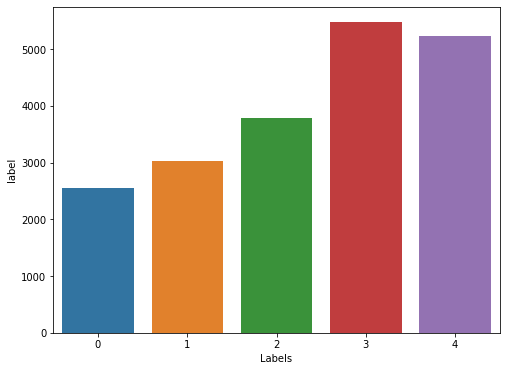

In [53]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x=train_final['label'].unique(), y=train_final['label'].value_counts())
ax.set(xlabel = 'Labels')

In [54]:
#DEFINE FIELD 

In [55]:
Text = torchtext.legacy.data.Field(sequential = True, tokenize = 'spacy', batch_first =True, include_lengths=True)
#Label = torchtext.legacy.data.LabelField(tokenize ='spacy', is_target=True, batch_first =True, sequential =False)
Label = torchtext.legacy.data.LabelField(dtype = torch.int64)

In [56]:
#Having defined those fields, we now need to produce a list that maps them onto the list of rows that are in the CSV:
#Text and Label ->Field 
#sentence and label ->column of dataframe 

In [57]:
datafields = [('sentence', Text),('label', Label)]

In [58]:
# lets convert from pandas to list to torchtext

In [59]:
train_example = [torchtext.legacy.data.Example.fromlist([train_final.sentence[i],train_final.label[i]], datafields) for i in range(train_final.shape[0])] 
test_example = [torchtext.legacy.data.Example.fromlist([test.sentence[i],test.label[i]], datafields) for i in range(test.shape[0])]

In [60]:
import os, pickle
with open(path+'train_example.pkl', 'wb') as train_it: 
    pickle.dump(train_example, train_it)
import os, pickle
with open(path+'test_example.pkl', 'wb') as train_it: 
    pickle.dump(test_example, train_it)

In [61]:
#CREATE DATASET

In [62]:
train_data = torchtext.legacy.data.Dataset(train_example, datafields)
valid_data = torchtext.legacy.data.Dataset(test_example, datafields)



In [63]:
(len(train_data), len(valid_data))

(20070, 2210)

In [64]:
print(vars(train_data[5]))

{'sentence': ['whether', 'or', 'not', 'you', 're', 'enlightened', 'by', 'any', 'of', 'derrida', ' ', 'lectures', 'on', 'the', 'other', 'and', 'the', 'self', 'derrida', 'is', 'an', 'undeniably', 'fascinating', 'and', 'playful', 'fellow'], 'label': 4}


In [65]:
vars(train_data.examples[11])

{'label': 2,
 'sentence': ['you',
  'should',
  'pay',
  'nine',
  'bucks',
  'for',
  'this',
  'because',
  'you',
  'can',
  'hear',
  'about',
  'suffering',
  'afghan',
  'refugees',
  'on',
  'the',
  'news',
  'and',
  'still',
  'be',
  'unaffected']}

In [66]:
print(vars(valid_data[5]))

{'sentence': ['Perhaps', 'no', 'picture', 'ever', 'made', 'has', 'more', 'literally', 'showed', 'that', 'the', 'road', 'to', 'hell', 'is', 'paved', 'with', 'good', 'intentions', '.'], 'label': 3}


In [67]:
# LETS  CREATE VOCABULARY
# WE CAN CREATE VOCAB OR WE CAN USE PRETRAINED VOCAB 

In [68]:
# MAX_VOCAB_SIZE = 18000

# Text.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
# Label.build_vocab(train_data)

Text.build_vocab(train_data)
Label.build_vocab(train_data)

In [69]:
#OPTION 2 :
# MAX_VOCAB_SIZE = 18_000

# Text.build_vocab(train_data,  
#                  vectors = "glove.6B.100d", 
#                  unk_init = torch.Tensor.normal_)

# Label.build_vocab(train_data)

In [70]:
#Text.vocab.vectors

In [71]:
print('Size of input vocab : ', len(Text.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appreared repeatedly :', list(Text.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  21574
Size of label vocab :  5
Top 10 words appreared repeatedly : [(' ', 19643), ('the', 17108), ('and', 10507), ('of', 10384), ('to', 7083), ('is', 5989), ('it', 5554), ('that', 4517), ('in', 4475), ('as', 2963)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 4: 3, 0: 4})


In [72]:
#Now we need to create a data loader to feed into our training loop. Torchtext provides the BucketIterator method that will produce what it calls a Batch, 
#which is almost, but not quite, like the data loader we used on images.

In [73]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits(
                                                                            (train_data, valid_data),
                                                                            batch_size = BATCH_SIZE,
                                                                            sort_key = lambda x: len(x.sentence),
                                                                            sort_within_batch= True, 
                                                                            device = device,
                                                                            shuffle=True)

In [74]:
print('Train')
for batch in train_iterator:
    print(f'Text matrix size: {batch.sentence[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break
    
print('\nValid:')
for batch in test_iterator:
    print(f'Text matrix size: {batch.sentence[0].size()}')
    print(f'Target vector size: {batch.label.size()}')
    break

Train
Text matrix size: torch.Size([128, 26])
Target vector size: torch.Size([128])

Valid:
Text matrix size: torch.Size([128, 7])
Target vector size: torch.Size([128])


In [75]:
# SAVE TOKENIZER 
import os, pickle
with open(path+'tokenizer_SST.pkl', 'wb') as tokens: 
    pickle.dump(Text.vocab.stoi, tokens)

In [76]:
# LETS CREATE OUR MODEL 

## DEFINING OUR MODEL 

We use the Embedding and LSTM modules in PyTorch to build a simple model for classifying sentences.

In this model we create three layers. 
1. First, the words in our tweets are pushed into an Embedding layer, which we have established as a 300-dimensional vector embedding. 
2. That’s then fed into a 2 stacked-LSTMs with 100 hidden features (again, we’re compressing down from the 300-dimensional input like we did with images). We are using 2 LSTMs for using the dropout.
3. Finally, the output of the LSTM (the final hidden state after processing the incoming sentences) is pushed through a standard fully connected layer with three outputs to correspond to our three possible classes (0,1,2,3,4).

In [85]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# class classifier(nn.Module):
    
#     # Define all the layers used in model
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,bidirectional, dropout):
        
#         super().__init__()          
        
#         # Embedding layer
#         self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
#         # LSTM layer
#         self.encoder = nn.LSTM(embedding_dim, 
#                            hidden_dim, 
#                            num_layers=n_layers, 
#                            dropout=dropout,
#                            bidirectional=bidirectional,
#                            batch_first=True)
#         # try using nn.GRU or nn.RNN here and compare their performances
#         # try bidirectional and compare their performances
        
#         # Dense layer
#         self.fc1 = nn.Linear(hidden_dim, 512)
#         self.fc2 = nn.Linear(512, output_dim)
#         self.dropout = nn.Dropout(dropout)

        
    # def forward(self, text, text_lengths):
        
    #     # text = [batch size, sent_length]
    #     embedded = self.embedding(text)
    #     # embedded = [batch size, sent_len, emb dim]
      
    #     # packed sequence
    #     packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
    #     packed_output, (hidden, cell) = self.encoder(packed_embedded)
    #     #hidden = [batch size, num layers * num directions,hid dim]
    #     #cell = [batch size, num layers * num directions,hid dim]
    
    #     # Hidden = [batch size, hid dim * num directions]
    #     #dense_outputs = self.fc(hidden)   
    #     output = F.relu(self.fc1(hidden))
    #     #         output = self.dropout(output)
    #     output = self.fc2(output)
    #     output = F.softmax(output[0], dim=1)
        
    #     # Final activation function softmax
    #     # output = F.softmax(dense_outputs[0], dim=1)
            
    #     return output
class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers,
                 bidirectional, dropout, pad_index):
        # Constructor
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)

        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim1,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim1 * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        # activation function
        self.act = nn.Softmax() #\ F.log_softmax(outp)

    def forward(self, text, text_lengths):
        # text = [batch size,sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        # packed sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True) # unpad

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # packed_output shape = (batch, seq_len, num_directions * hidden_size)
        # hidden shape  = (num_layers * num_directions, batch, hidden_size)

        # concat the final forward and backward hidden state
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        # output, output_lengths = pad_packed_sequence(packed_output)  # pad the sequence to the max length in the batch

        rel = self.relu(cat)
        dense1 = self.fc1(rel)

        drop = self.dropout(dense1)
        preds = self.fc2(drop)

        # Final activation function
        # preds = self.act(preds)
        # preds = preds.argmax(dim=1).unsqueeze(0)
        return preds



In [78]:
#HYPER PARAMETER 

In [79]:
# Define hyperparameters
size_of_vocab = len(Text.vocab)
embedding_dim = 100
num_hidden_nodes = 256
num_output_nodes = len(Label.vocab)
num_layers = 2
dropout = 0.2
PAD_IDX = Text.vocab.stoi[Text.pad_token]

hidden_dim2 = 128
bi_directional = True

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, hidden_dim2, num_output_nodes, num_layers, bi_directional, dropout = dropout, pad_index=PAD_IDX)

In [80]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(21574, 100, padding_idx=1)
  (lstm): LSTM(100, 256, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Softmax(dim=None)
)
The model has 4,533,853 trainable parameters


In [81]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()


# # define metric
# def binary_accuracy(preds, y):
#     #round predictions to the closest integer
#     _, predictions = torch.max(preds, 1)
    
#     correct = (predictions == y).float() 
#     acc = correct.sum() / len(correct)
#     return acc


# define metric
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)


In [82]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        tweet, tweet_lengths = batch.sentence
        
        # convert to 1D tensor
        predictions = model(tweet, tweet_lengths).squeeze()  
        
        # compute the loss
        loss = criterion(predictions, batch.label)        
        
        # compute the binary accuracy
        # acc = binary_accuracy(predictions, batch.label)   

        # compute the categorical accuracy
        acc = categorical_accuracy(predictions, batch.label)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            text, text_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.label)
            # compute the binary accuracy
            # acc = binary_accuracy(predictions, batch.label)   

            # compute the categorical accuracy
            acc = categorical_accuracy(predictions, batch.label)  
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [83]:
# load train and test iteraror


In [86]:
N_EPOCHS = 50
best_valid_loss = float('inf')

train_loss_epoch=[]
valid_loss_epoch=[]
train_acc_epoch=[]
valid_acc_epoch=[]

for epoch in range(N_EPOCHS):
    print("epoch :---->",epoch)
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path+'saved_weights_SST.pt')

    train_loss_epoch.append(train_loss)
    valid_loss_epoch.append(valid_loss)
    train_acc_epoch.append(train_acc)
    valid_acc_epoch.append(valid_acc)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

epoch :----> 0
	Train Loss: 1.572 | Train Acc: 26.83%
	 Val. Loss: 1.572 |  Val. Acc: 24.82% 

epoch :----> 1
	Train Loss: 1.534 | Train Acc: 31.41%
	 Val. Loss: 1.549 |  Val. Acc: 28.12% 

epoch :----> 2
	Train Loss: 1.483 | Train Acc: 34.72%
	 Val. Loss: 1.535 |  Val. Acc: 32.85% 

epoch :----> 3
	Train Loss: 1.415 | Train Acc: 39.06%
	 Val. Loss: 1.526 |  Val. Acc: 33.52% 

epoch :----> 4
	Train Loss: 1.326 | Train Acc: 44.13%
	 Val. Loss: 1.502 |  Val. Acc: 32.60% 

epoch :----> 5
	Train Loss: 1.208 | Train Acc: 49.97%
	 Val. Loss: 1.505 |  Val. Acc: 34.00% 

epoch :----> 6
	Train Loss: 1.077 | Train Acc: 55.85%
	 Val. Loss: 1.522 |  Val. Acc: 32.89% 

epoch :----> 7
	Train Loss: 0.961 | Train Acc: 60.92%
	 Val. Loss: 1.592 |  Val. Acc: 33.64% 

epoch :----> 8
	Train Loss: 0.857 | Train Acc: 65.45%
	 Val. Loss: 1.616 |  Val. Acc: 33.62% 

epoch :----> 9
	Train Loss: 0.738 | Train Acc: 70.77%
	 Val. Loss: 1.819 |  Val. Acc: 32.84% 

epoch :----> 10
	Train Loss: 0.646 | Train Acc: 74

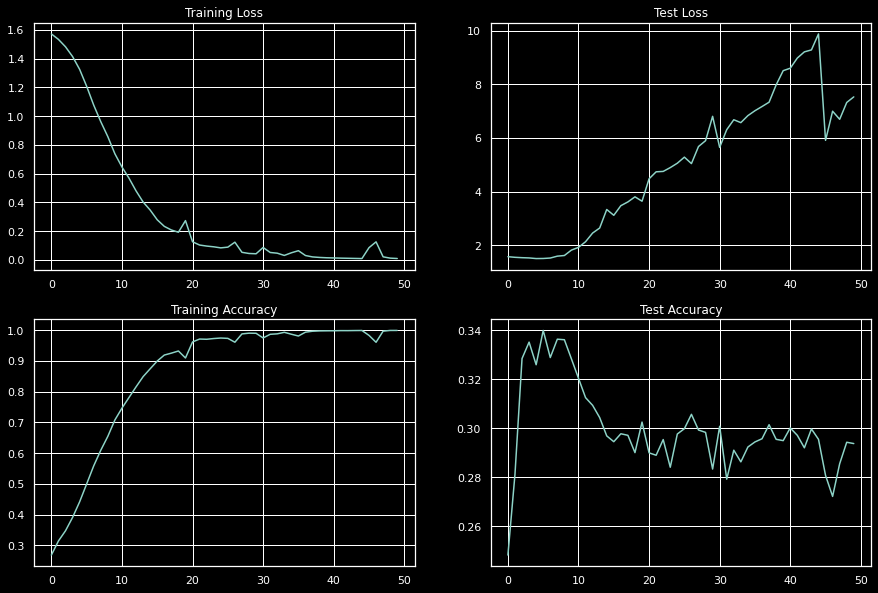

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
plt.style.use("dark_background")

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_epoch)
axs[0, 0].set_title("Training Loss")
axs[0, 1].plot(valid_loss_epoch)
axs[0, 1].set_title("Test Loss")
axs[1, 0].plot(train_acc_epoch)
axs[1, 0].set_title("Training Accuracy")
axs[1, 1].plot(valid_acc_epoch)
axs[1, 1].set_title("Test Accuracy")
plt.show()

In [ ]:
valid_acc

In [88]:
# LOAD  SAVED MODEL 


In [89]:
model_path=path+'/saved_weights_SST.pt'
model.load_state_dict(torch.load(model_path));
model.eval();
tokenizer_file = open(path+'./tokenizer_SST.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)



import spacy
nlp = spacy.load('en')

def classify_text(tweet):
    
    categories = {0: "0", 1:"1", 2:"2", 3:"3", 4:"4"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(tweet)] 
    # convert to integer sequence using predefined tokenizer dictionary
    indexed = [tokenizer[t] for t in tokenized]        
    # compute no. of words        
    length = [len(indexed)]
    # convert to tensor                                    
    tensor = torch.LongTensor(indexed).to(device)   
    # reshape in form of batch, no. of words           
    tensor = tensor.unsqueeze(1).T  
    # convert to tensor                          
    length_tensor = torch.LongTensor(length)
    # Get the model prediction                  
    prediction = model(tensor, length_tensor)
    print(prediction)

    #_, pred = torch.max(prediction, 1) 
    pred = prediction.argmax(1, keepdim = True)
    
    return categories[pred.item()]

In [90]:
#for individual prediction 
classify_text("The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal good bad worst   ")

tensor([[-0.0949,  0.4165, -0.6372,  0.0369,  0.4248]], device='cuda:0',
       grad_fn=<AddmmBackward>)


'4'

In [91]:
test.head()

,label,sentence
0,2,Effective but too-tepid biopic
1,3,If you sometimes like to go to the movies to h...
2,4,"Emerges as something rare , an issue movie tha..."
3,2,The film provides some great insight into the ...
4,4,Offers that rare combination of entertainment ...


In [92]:
test1=test
test1['pred_label']=test1.sentence.apply(classify_text)

tensor([[-0.3078,  1.2896,  0.1728, -1.5646, -0.1101]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.4161,  0.1042, -0.1097,  0.0644, -0.3221]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6206,  0.1491, -0.6236,  0.1699, -0.1086]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 1.5344,  0.5611,  0.4555, -1.3419, -1.6299]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2199,  0.1831, -0.6567,  0.3254,  0.2096]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[-0.0675,  0.8603,  0.1173, -1.1683, -0.0209]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.2753,  0.4004,  0.0816, -0.4917, -0.3760]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.8836,  0.5974,  0.2771, -1.2468, -0.9441]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 0.6391, -0.0900, -0.5580,  0.7644, -0.3473]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([[ 1.4424, -0.4595, -0.6098,  1.3568, -1.0912]],

In [101]:
test1.head(20)

,label,sentence,pred_label
0,2,Effective but too-tepid biopic,1
1,3,If you sometimes like to go to the movies to h...,0
2,4,"Emerges as something rare , an issue movie tha...",0
3,2,The film provides some great insight into the ...,0
4,4,Offers that rare combination of entertainment ...,3
5,3,Perhaps no picture ever made has more literall...,1
6,3,Steers turns in a snappy screenplay that curls...,1
7,3,But he somehow pulls it off .,0
8,3,Take Care of My Cat offers a refreshingly diff...,3
9,4,"This is a film well worth seeing , talking and...",0


In [94]:
test1.pred_label.value_counts()

0    928
1    782
3    301
4    193
2      6
Name: pred_label, dtype: int64

In [95]:
test1.label.value_counts()

1    633
3    510
4    399
2    389
0    279
Name: label, dtype: int64

In [96]:
test1.to_csv(path+"result_test.csv")

In [99]:
test_correct =test1[test1['label'] == test1['pred_label']]
test_incorrect =test1[(test1.label != test1.pred_label ) ]                  